In [ ]:
# importing the necessary modules

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn import preprocessing
from tqdm import tqdm
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding


In [ ]:
# loading the dataset

df_train = pd.read_csv("training_task_a_tweets.csv")
df_test = pd.read_csv("test_a.csv")

In [ ]:
df_train.head()

,id,in_reply_to_status_id_str,text,user.verified,user.followers_count,retweet_count,favorite_count,entities.hashtags,entities.urls,label
0,552785374507175936,552783667052167168,MT @euronews France: 10 dead after shooting at...,False,1828,1,2,"[{'indices': [70, 83], 'text': 'CharlieHebdo'}]",[],comment
1,552786226546495488,552785374507175936,@j0nathandavis They who? Stupid and partial op...,False,405,0,0,[],[],deny
2,552789345628069888,552786226546495488,"@nanoSpawn Socialists, Antisemites, anti zioni...",False,1828,0,0,[],[],comment
3,552792862610694144,552783667052167168,@euronews @TradeDesk_Steve A French crime of p...,False,26,0,0,[],[],query
4,552943855021330432,552783667052167168,"@euronews LOL. 5 million Muslims in France, wh...",False,14,0,0,[],[],comment


In [ ]:
df_train.label.unique()

array(['comment', 'deny', 'query', 'support'], dtype=object)

In [ ]:
#dropping the unwanted columns and converting the text into lower

df_train.drop(df_train.columns[[0, 1,3,4,5,6,7,8]], axis = 1, inplace = True)
df_test.drop(df_test.columns[[0, 1,3,4,5,6,7,8]], axis = 1, inplace = True)
df_train["text"]=df_train["text"].str.lower()
df_test["text"]=df_test["text"].str.lower()

In [ ]:
df_train.head()

,text,label
0,mt @euronews france: 10 dead after shooting at...,comment
1,@j0nathandavis they who? stupid and partial op...,deny
2,"@nanospawn socialists, antisemites, anti zioni...",comment
3,@euronews @tradedesk_steve a french crime of p...,query
4,"@euronews lol. 5 million muslims in france, wh...",comment


In [ ]:
import nltk
nltk.download('stopwords')
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D,Flatten, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
import re
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#Applying the necessary preprocessing techniques

def getLemmText(text):
 tokens=word_tokenize(text)
 lemmatizer = WordNetLemmatizer()
 tokens=[lemmatizer.lemmatize(word) for word in tokens]
 return ' '.join(tokens)
def stop_words(text):
  text = REPLACE_BY_SPACE_RE.sub(' ', text)
  text = BAD_SYMBOLS_RE.sub('', text)
  text = ' '.join(word for word in text.split() if word not in STOPWORDS)
  return text
def getStemmText(text):
 tokens=word_tokenize(text)
 ps = PorterStemmer()
 tokens=[ps.stem(word) for word in tokens]
 return ' '.join(tokens)

In [ ]:
df_train['text'] = list(map(stop_words,df_train['text']))
df_train['text'] = list(map(getLemmText,df_train['text']))
df_train['text'] = list(map(getStemmText,df_train['text']))


df_test['text'] = list(map(stop_words,df_test['text']))
df_test['text'] = list(map(getLemmText,df_test['text']))
df_test['text'] = list(map(getStemmText,df_test['text']))

In [ ]:
# converting the categorical text values into label encoding

label_encoder = preprocessing.LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train.label.values)
df_test['label'] = label_encoder.fit_transform(df_test.label.values)

In [ ]:
ytrain = df_train["label"]
ytest = df_test["label"]
xtrain = df_train["text"]
xtest = df_test["text"]

In [ ]:
# Loading the pre-trained GLOVE embeddings

embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in tqdm(f):
 values = line.split()
 word = values[0]
 coefs = np.asarray(values[1:], dtype='float32')
 embeddings_index[word] = coefs
f.close()


2449it [00:00, 28700.66it/s]


In [ ]:
# defining the necessary parameters for the glove text vector

VOCABULARY_SIZE, MAX_LENGTH = 2000,60

In [ ]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(list(xtrain) + list(xtest))

In [ ]:

xtrain_sequence = tokenizer.texts_to_sequences(xtrain)
xtest_sequence = tokenizer.texts_to_sequences(xtest)

In [ ]:
# padding the input text

xtrain_padding = sequence.pad_sequences(xtrain_sequence, maxlen=MAX_LENGTH)
xtest_padding = sequence.pad_sequences(xtest_sequence, maxlen=MAX_LENGTH)
word_index = tokenizer.word_index

In [ ]:
# converting the word embedding into embedding matrix

embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in tqdm(word_index.items()):
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
  embedding_matrix[i] = embedding_vector

100%|██████████| 8519/8519 [00:00<00:00, 772668.36it/s]


In [ ]:
# Defining the model with BiLSTM and feed forward neural networks with dense layers having relu activation and output with softmax activation

model = Sequential()
model.add(Embedding(len(word_index) + 1,100,weights=[embedding_matrix],input_length=MAX_LENGTH,trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


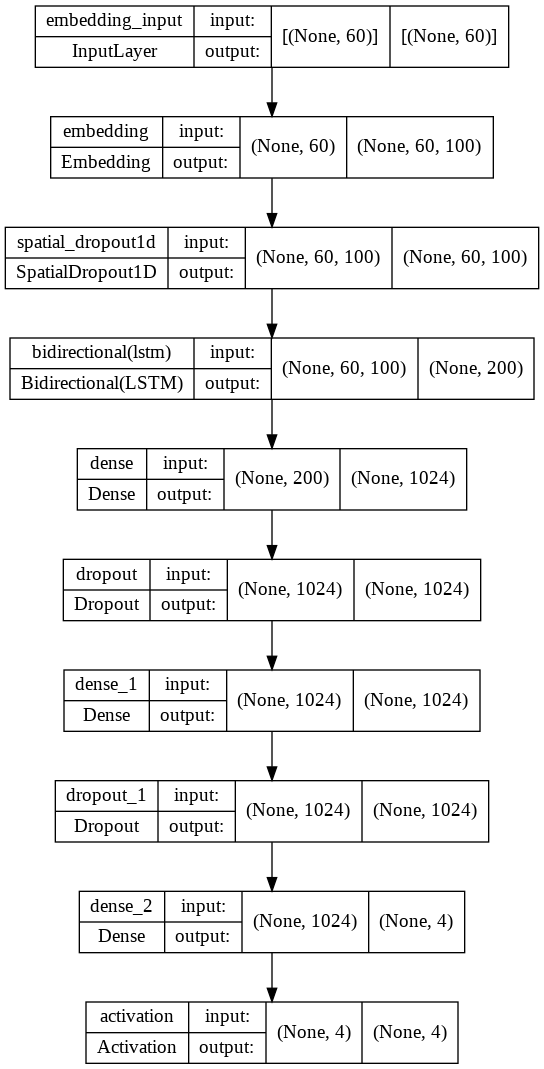

In [ ]:
#print(model.summary())
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [ ]:
# converting the target label into categorical

ytrain_encode = np_utils.to_categorical(ytrain)
ytest_encode = np_utils.to_categorical(ytest)

In [ ]:
# training the model with necessary epoch and batch size

history = model.fit(xtrain_padding, y=ytrain_encode, batch_size=512, epochs=50, verbose=1, validation_data=(xtest_padding, ytest_encode))

Epoch 1/50
9/9 [==============================] - 14s 679ms/step - loss: 1.1258 - accuracy: 0.6360 - val_loss: 0.8822 - val_accuracy: 0.7634
Epoch 2/50
9/9 [==============================] - 6s 706ms/step - loss: 1.0052 - accuracy: 0.6859 - val_loss: 0.8560 - val_accuracy: 0.7634
Epoch 3/50
9/9 [==============================] - 6s 732ms/step - loss: 0.9772 - accuracy: 0.6859 - val_loss: 0.8902 - val_accuracy: 0.7634
Epoch 4/50
9/9 [==============================] - 6s 622ms/step - loss: 0.9692 - accuracy: 0.6859 - val_loss: 0.8239 - val_accuracy: 0.7634
Epoch 5/50
9/9 [==============================] - 6s 617ms/step - loss: 0.9564 - accuracy: 0.6859 - val_loss: 0.8657 - val_accuracy: 0.7634
Epoch 6/50
9/9 [==============================] - 6s 629ms/step - loss: 0.9563 - accuracy: 0.6859 - val_loss: 0.8182 - val_accuracy: 0.7634
Epoch 7/50
9/9 [==============================] - 6s 635ms/step - loss: 0.9570 - accuracy: 0.6859 - val_loss: 0.8525 - val_accuracy: 0.7634
Epoch 8/50
9/9 [===

In [ ]:
# evaluating the model

score = model.evaluate(xtest_padding, ytest_encode, verbose=1)

32/32 [==============================] - 1s 37ms/step - loss: 0.8160 - accuracy: 0.7634


In [ ]:
# calculating the f1 score

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(xtest_padding)
y_pred = np.argmax(y_pred1, axis=1)
print(f1_score(ytest, y_pred , average="macro"))

0.22542921738787036
